# Model Report

In [1]:
import logging
from time import time
from typing import Optional

import arviz as az
import matplotlib.pyplot as plt

from speclet import model_configuration
from speclet.analysis.arviz_analysis import describe_mcmc
from speclet.bayesian_models import get_bayesian_model
from speclet.io import project_root
from speclet.loggers import set_console_handler_level
from speclet.managers.cache_manager import (
    get_cached_posterior,
    get_posterior_cache_name,
)
from speclet.project_configuration import get_bayesian_modeling_constants
from speclet.project_enums import ModelFitMethod

In [2]:
notebook_tic = time()
set_console_handler_level(logging.WARNING)
%config InlineBackend.figure_format = "retina"
HDI_PROB = get_bayesian_modeling_constants().hdi_prob

Parameters for papermill:

- `MODEL_NAME`: name of the model
- `FIT_METHOD`: method used to fit the model; either "ADVI" or "MCMC"
- `CONFIG_PATH`: path to configuration file
- `ROOT_CACHE_DIR`: path to the root caching directory

## Setup

### Papermill parameters

In [3]:
CONFIG_PATH = ""
MODEL_NAME = ""
FIT_METHOD_STR = ""
ROOT_CACHE_DIR = ""

In [4]:
# Parameters
MODEL_NAME = "simple-nb"
FIT_METHOD_STR = "STAN_MCMC"
CONFIG_PATH = "models/model-configs.yaml"
ROOT_CACHE_DIR = "models"

In [5]:
FIT_METHOD = ModelFitMethod(FIT_METHOD_STR)
model_config = model_configuration.get_configuration_for_model(
    config_path=project_root() / CONFIG_PATH, name=MODEL_NAME
)
model = get_bayesian_model(model_config.model)()
trace = get_cached_posterior(
    get_posterior_cache_name(MODEL_NAME, FIT_METHOD),
    cache_dir=project_root() / ROOT_CACHE_DIR,
)

## Fit diagnostics

R-HAT
<xarray.Dataset>
Dimensions:         (mu_dim_0: 2188, log_lik_dim_0: 2188, y_hat_dim_0: 2188)
Coordinates:
  * mu_dim_0        (mu_dim_0) int64 0 1 2 3 4 5 ... 2183 2184 2185 2186 2187
  * log_lik_dim_0   (log_lik_dim_0) int64 0 1 2 3 4 ... 2183 2184 2185 2186 2187
  * y_hat_dim_0     (y_hat_dim_0) int64 0 1 2 3 4 5 ... 2183 2184 2185 2186 2187
Data variables:
    beta            float64 1.001
    reciprocal_phi  float64 1.0
    eta             float64 1.001
    mu              (mu_dim_0) float64 1.001 1.001 1.001 ... 1.001 1.001 1.001
    phi             float64 1.0
    log_lik         (log_lik_dim_0) float64 1.001 1.001 1.001 ... 0.9996 1.001
    y_hat           (y_hat_dim_0) float64 0.9997 1.0 0.9998 ... 1.003 0.9992 1.0
sampled 2 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 0, 0
percent divergences: 0.0, 0.0
BFMI: 1.14, 1.153
avg. step size: 0.908, 0.922


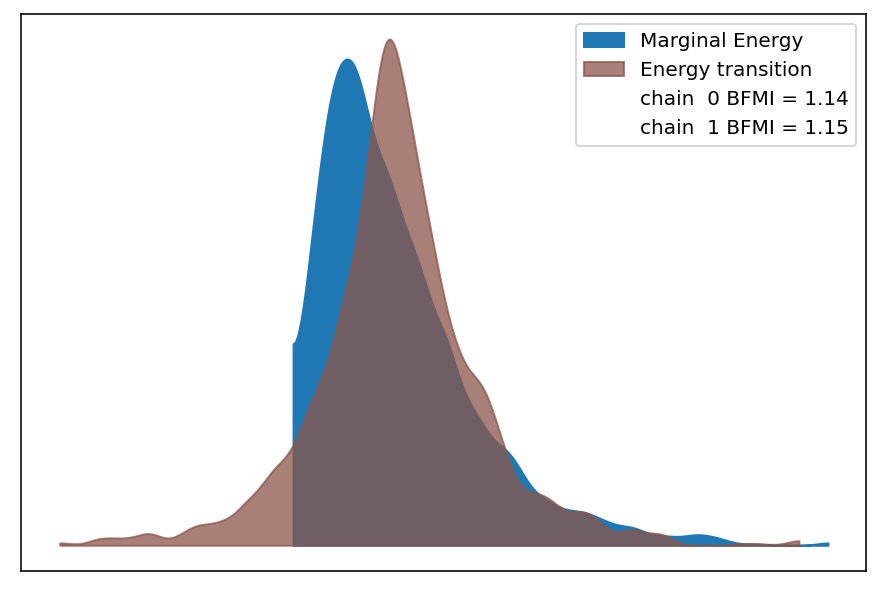

In [6]:
if "MCMC" in FIT_METHOD.value:
    print("R-HAT")
    print(az.rhat(trace))
    print("=" * 60)
    describe_mcmc(trace)

## Model parameters

In [7]:
var_regex = model.vars_regex(FIT_METHOD)
var_regex += ["~log_lik", "~y_hat"]

In [8]:
def _as_int(x: float) -> str:
    return str(int(x))


az.summary(
    trace, var_names=var_regex, filter_vars="regex", hdi_prob=HDI_PROB
).style.format(formatter={"ess_bulk": _as_int, "ess_tail": _as_int}, precision=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.09,0.01,0.07,0.11,0.00,0.00,2073,1481,1.00
eta,0.09,0.01,0.07,0.11,0.00,0.00,2073,1481,1.00
phi,2.62,0.08,2.49,2.74,0.00,0.00,1856,1218,1.00


/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_96731/2160019948.py:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


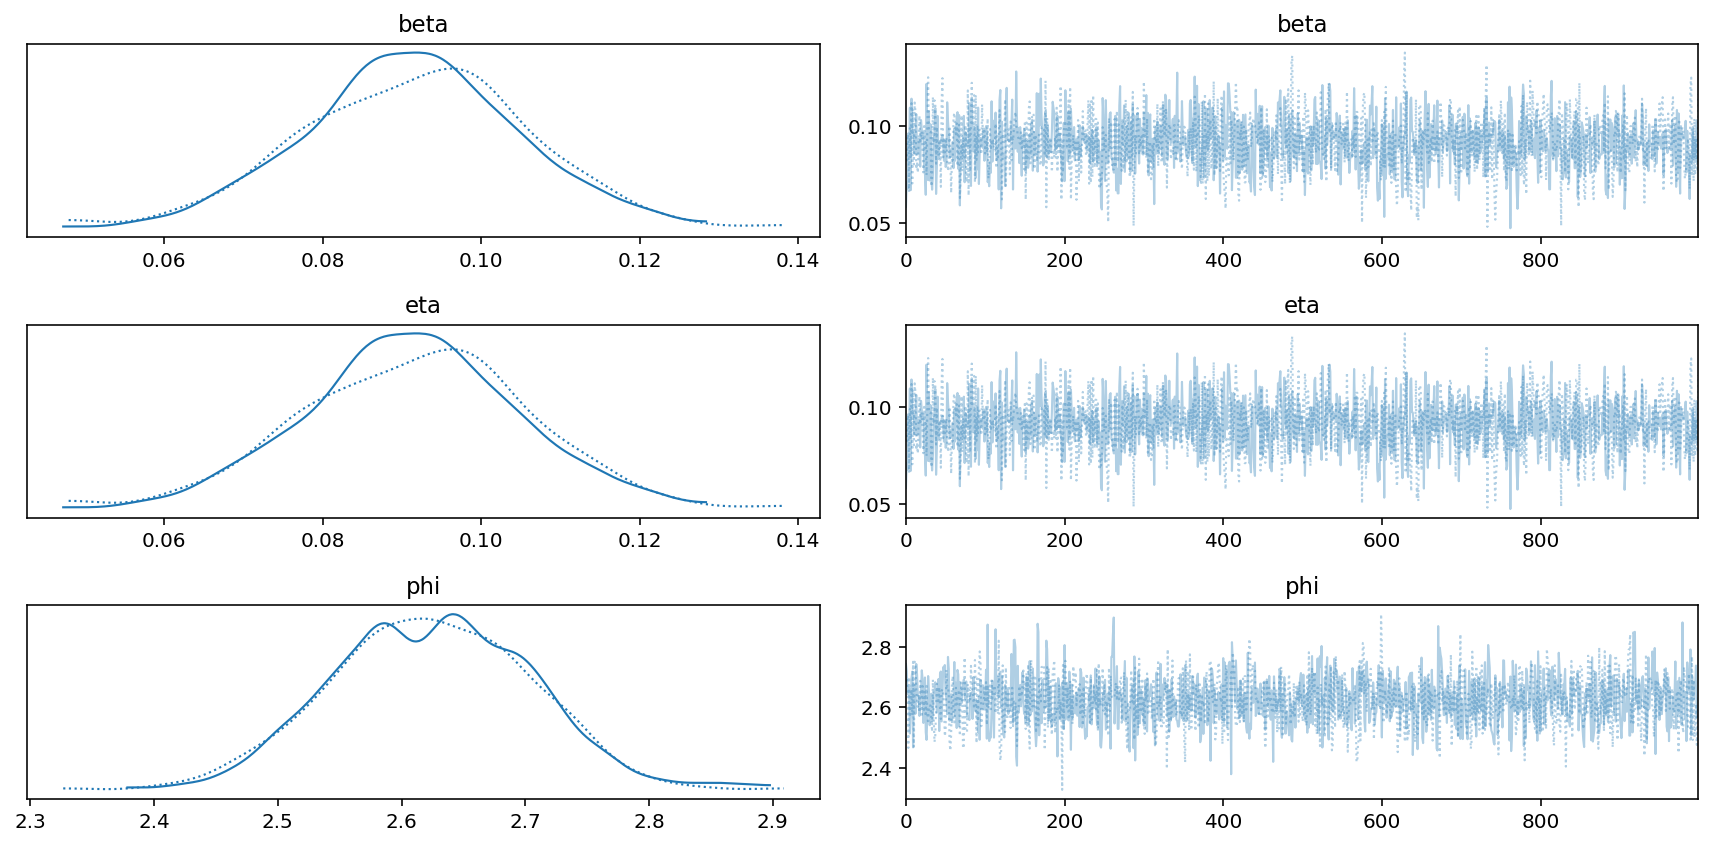

In [9]:
az.plot_trace(trace, var_names=var_regex, filter_vars="regex")
plt.tight_layout()
plt.show()

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_96731/263103266.py:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


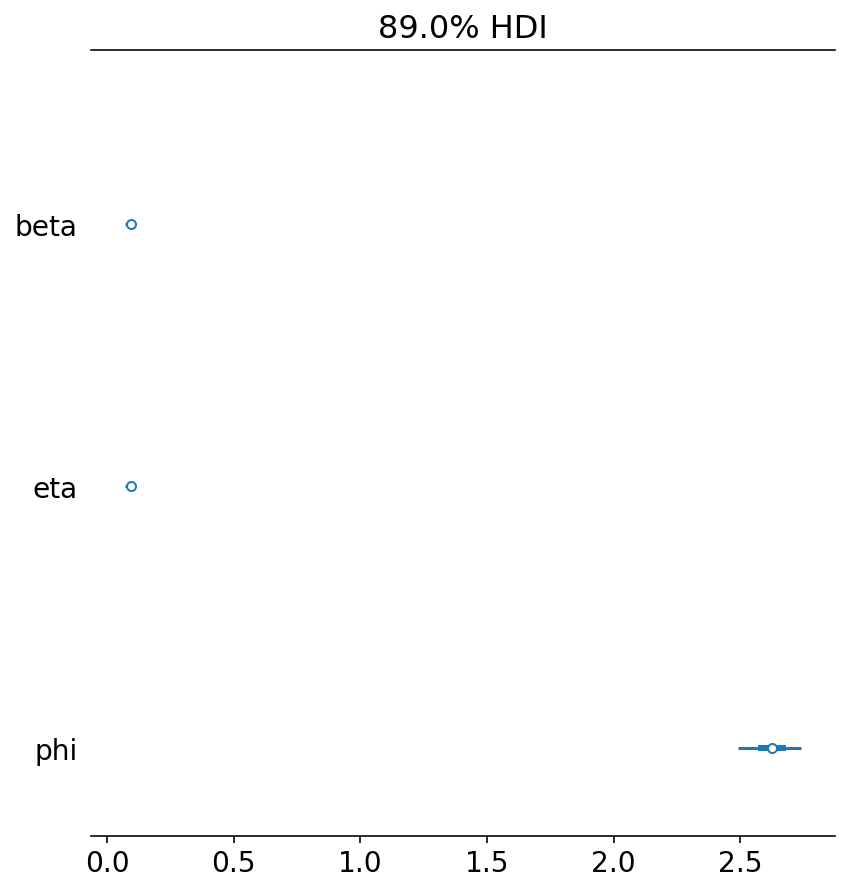

In [10]:
az.plot_forest(
    trace, var_names=var_regex, filter_vars="regex", hdi_prob=HDI_PROB, combined=True
)
plt.tight_layout()
plt.show()

## Model predictions

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_96731/1880208410.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


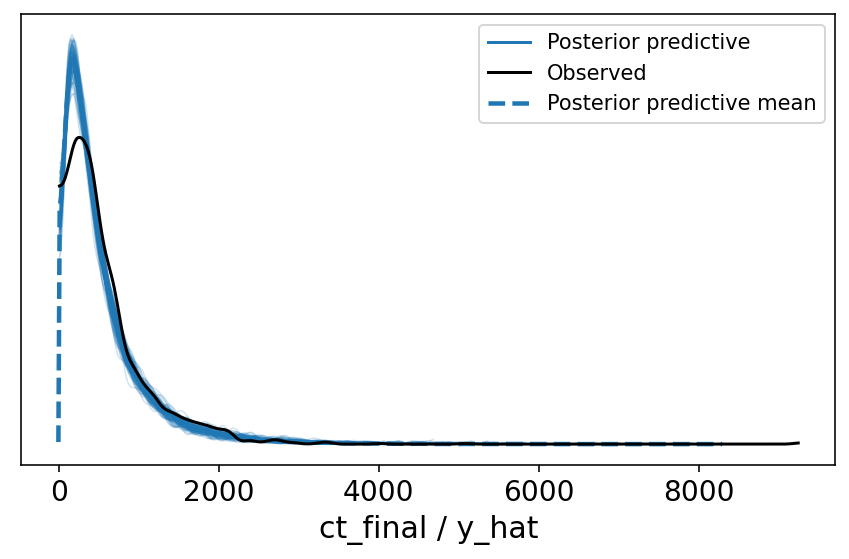

In [11]:
data_pairs: Optional[dict[str, str]] = None

# NOTE: This is a bit of a hack for now...
if FIT_METHOD is ModelFitMethod.STAN_MCMC:
    # obs_var = model.stan_idata_addons["observed_data"][0]
    # ppc_var = model.stan_idata_addons["posterior_predictive"][0]
    obs_var = list(trace.observed_data.data_vars.keys())[0]
    ppc_var = list(trace.posterior_predictive.data_vars.keys())[0]
    data_pairs = {obs_var: ppc_var}


az.plot_ppc(trace, data_pairs=data_pairs, num_pp_samples=100, random_seed=123)
plt.tight_layout()
plt.show()

In [12]:
psis_loo = az.loo(trace, pointwise=True)
psis_loo

Computed from 2000 by 2188 log-likelihood matrix

         Estimate       SE
elpd_loo -15080.76    54.64
p_loo        4.59        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2188  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_96731/3910446358.py:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


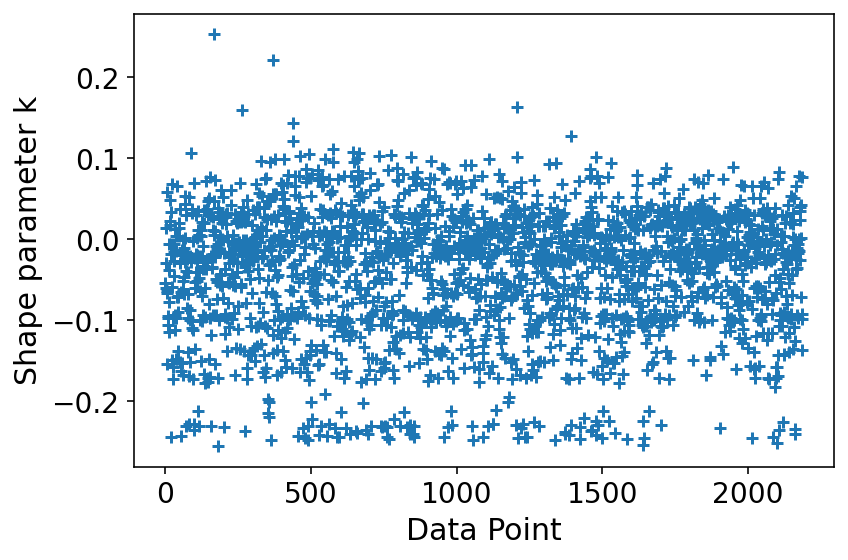

In [13]:
az.plot_khat(psis_loo)
plt.tight_layout()
plt.show()

---

In [14]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.45 minutes


In [15]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-01-20

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: nb-model

logging   : 0.5.1.2
matplotlib: 3.5.1
speclet   : 0.0.9000
arviz     : 0.11.2

